In [88]:
import bisect
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate
import seaborn as sns
from networkx.drawing.nx_pydot import graphviz_layout
# import pydot
from google.cloud import storage

import dalmatian 
import model_helper 
from helper import *
from scipy.stats import iqr

In [89]:
# Load wbc and treatment file 
wbc_file = 'CRC-0037_wbc.txt'
treatment = pd.read_csv("CRC_0037.txt", sep = '\t')


# Get input files from Terra through dalmatian
patient = 'CLL-CRC-0037'
workspace ='broad-firecloud-ibmwatson/Getz-IBM-Wu_Fludarabine_Resistance-Analysis'
wm = dalmatian.WorkspaceManager(workspace)
participants = wm.get_participants()

cluster_CCF_df = pd.read_csv(participants.loc[patient]['cluster_ccfs_Aug2'], sep='\t')
participants = wm.get_participants()
abundance_df = pd.read_csv(participants.loc[patient]['abundances_tsv_Aug2'], sep='\t')
mcmc_df = pd.read_csv(participants.loc[patient]['cell_population_mcmc_trace_Aug2'], sep='\t')
tree_df = pd.read_csv(participants.loc[patient]['tree_tsv_Aug2'], sep='\t')

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
times_sample, times, times_interpolate, wbc, wbc_interpolate, sample_list, wbc_sample, times_others = model_helper.load_wbc_file(wbc_file)

In [ ]:
def select_wbc(dfd, times, wbc, times_sample):
    '''
    select wbc until the first treatment after last sequencing sample

    Args:
        dfd: first treatment dfd after last sequencing sample
    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd]

    smallest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)

    wbc_selected = wbc[0: smallest_index+ 1]

    return times_selected, wbc_selected

In [ ]:
times_selected, wbc_selected = select_wbc(4674, times, wbc, times_sample)

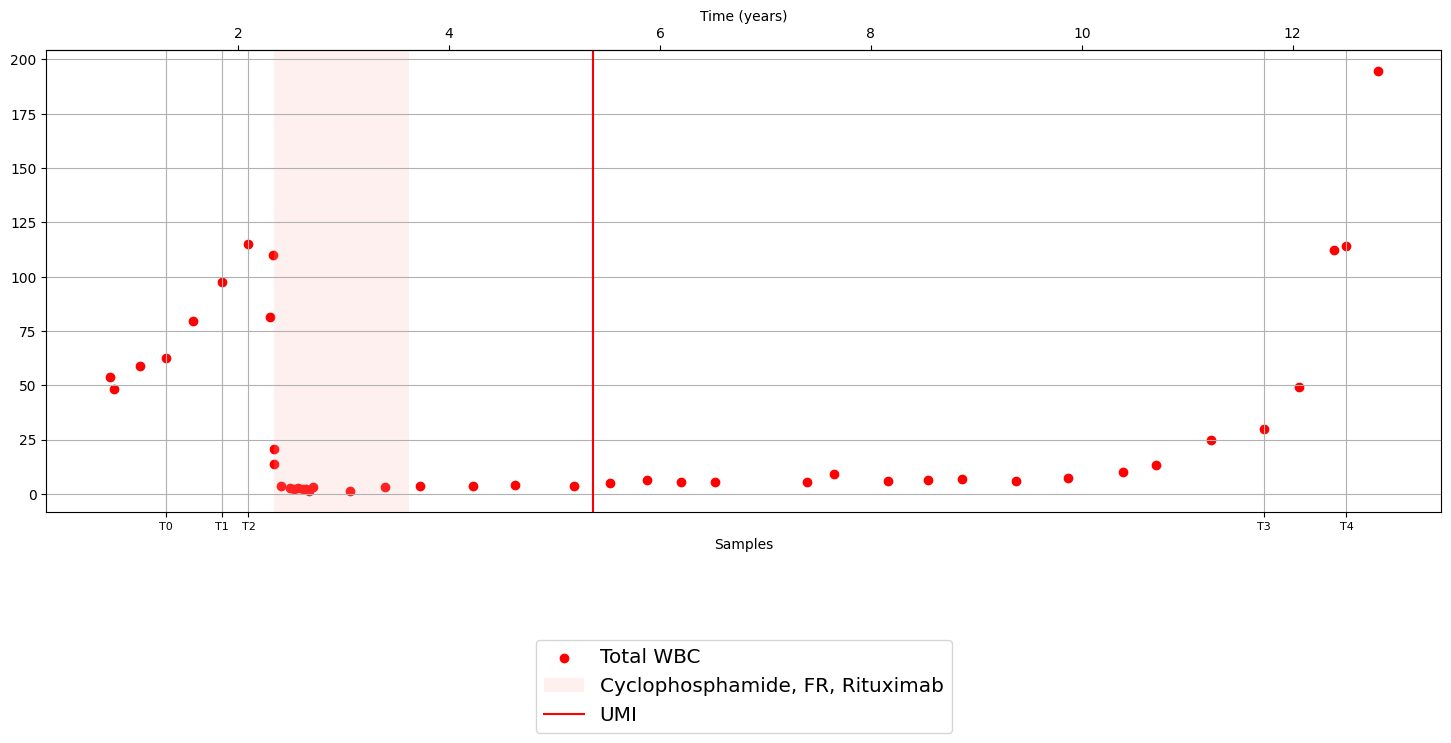

In [90]:
fig,ax = plt.subplots(1,1, figsize=(18,6))

number_samples = len(sample_list)
tick_list = ['T'+ str(i) for i in range(number_samples)]

x_year = [ i/365 for i in np.array(times_selected)]
ax.scatter(x_year,wbc_selected, label = 'Total WBC', c = 'red')
plt.yscale("linear")
x_axis = [i/365 for i in times_sample]
ax.set_xticks(x_axis)

ax.set_xticklabels(tick_list, fontsize =8)
secax = ax.secondary_xaxis('top')
secax.set_xlabel("Time (years)")
ax.grid(True)


cmap = plt.get_cmap("Pastel1")
xlim = ax.get_xlim()[1]

for i, row in treatment.iterrows():
    treatment_name = row.tx
    start = row.tx_start/365
    end = row.tx_end/365
    if np.isnan(end):
        end = xlim
    length = end - start 
    center = (start + end)/2
#         color = color_dict[treatment_name]
    ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
    ax.set_xlabel('Samples')

# add potential UMI samples
ax.axvline(x=1958/365, label ='UMI', color = 'red')

ax.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.5),fontsize = 'x-large')


Subclonal modeling

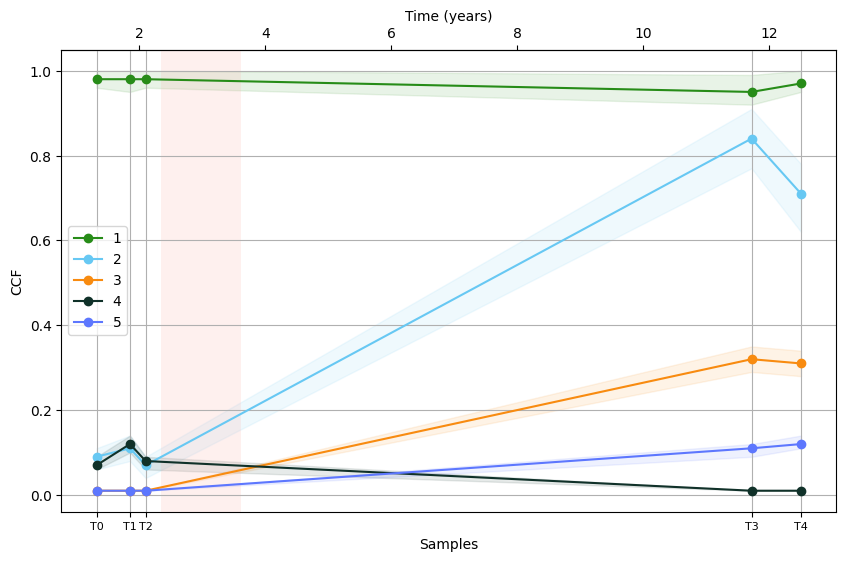

In [91]:
fig, ax = plt.subplots(figsize = (10, 6))
model_helper.plot_ccf(cluster_CCF_df,ax, times_sample, treatment)

In [92]:
cluster_list, cluster_abundance = model_helper.get_abundance(abundance_df, mcmc_df, sample_list)

In [93]:
cluster_abundance

{1: [0.92, 0.85, 0.92, 0.0, 0.0],
 2: [0.0, 0.0, 0.0, 0.73, 0.55],
 3: [0.01, 0.01, 0.01, 0.1, 0.3],
 4: [0.06, 0.11, 0.05, 0.01, 0.01],
 5: [0.01, 0.01, 0.01, 0.12, 0.12]}

In [94]:
# calculate only at sample points
subclone_sample, log_subclone_sample = model_helper.calc_subclone(wbc_sample, cluster_abundance, cluster_list)


In [95]:
all_abundance = model_helper.get_all_abundance(cluster_list, mcmc_df, sample_list, times_sample, )

In [102]:
#  Add noise to all abundance

import random 

def add_uniform_noise_and_normalize(lst, low=0, high=0.01, seed = 42):
    
    
    random.seed(seed)
    # Add uniform noise
    noisy_lst = [x + random.uniform(low, high) for x in lst]

    
    # Normalize the list
    total_sum = sum(noisy_lst)
    
    normalized_lst = [x / total_sum for x in noisy_lst]

    return normalized_lst


subclone_cluster_iter = {}
# Iterate through each cluster
for cluster, iterations in all_abundance.items():
   
    # Iterate through each iteration in the cluster
    for iteration, value in iterations.items():
        # If the iteration is not in the new dict, add it
        if iteration not in subclone_cluster_iter:
            subclone_cluster_iter[iteration] = {}
        # Add the cluster and its value to this iteration
        subclone_cluster_iter[iteration][cluster] = value

        
        
noise_added_iter = {}

for iteration, abundances in subclone_cluster_iter.items():
    
    transposed_data = {i: list(values) for i, values in enumerate(zip(*abundances.values()), start=1)}
    
    noise_added_iter[iteration] = {}
    for time_point, abundance in transposed_data.items():
        
#         print(time_point, abundance)
        noise_abundance = add_uniform_noise_and_normalize(abundance)
    
#         print(noise_abundance)

        noise_added_iter[iteration][time_point] = add_uniform_noise_and_normalize(abundance)

    
noise_added_all_abundance = {}
for iteration, abundances in noise_added_iter.items():
    original_format = {i + 1: list(values) for i, values in enumerate(zip(*abundances.values()))}
    noise_added_all_abundance[iteration] = original_format
    
    
noise_added_original_all_abundances = {}

for iteration, abundances in noise_added_all_abundance.items():
    
    for cluster, abundance_value in abundances.items():
        if cluster not in noise_added_original_all_abundances:
            noise_added_original_all_abundances[cluster] = {}
        noise_added_original_all_abundances[cluster][iteration] = abundance_value
            

In [100]:
all_abundance

{1: {0: [0.92, 0.85, 0.93, 0.0, 0.0],
  1: [0.87, 0.88, 0.88, 0.0, 0.0],
  2: [0.91, 0.84, 0.9, 0.0, 0.0],
  3: [0.91, 0.86, 0.95, 0.0, 0.03],
  4: [0.89, 0.82, 0.91, 0.0, 0.0],
  5: [0.93, 0.84, 0.93, 0.0, 0.0],
  6: [0.91, 0.86, 0.88, 0.0, 0.0],
  7: [0.89, 0.87, 0.92, 0.0, 0.0],
  8: [0.91, 0.83, 0.92, 0.0, 0.0],
  9: [0.87, 0.88, 0.89, 0.0, 0.02],
  10: [0.91, 0.87, 0.92, 0.0, 0.0],
  11: [0.9, 0.89, 0.88, 0.0, 0.0],
  12: [0.88, 0.78, 0.91, 0.0, 0.04],
  13: [0.9, 0.85, 0.87, 0.0, 0.0],
  14: [0.86, 0.86, 0.92, 0.0, 0.0],
  15: [0.9, 0.85, 0.88, 0.0, 0.0],
  16: [0.9, 0.86, 0.93, 0.0, 0.0],
  17: [0.87, 0.86, 0.91, 0.0, 0.0],
  18: [0.88, 0.81, 0.93, 0.0, 0.0],
  19: [0.82, 0.79, 0.89, 0.0, 0.0],
  20: [0.89, 0.85, 0.89, 0.0, 0.0],
  21: [0.91, 0.85, 0.88, 0.0, 0.0],
  22: [0.89, 0.87, 0.92, 0.0, 0.01],
  23: [0.9, 0.88, 0.86, 0.0, 0.0],
  24: [0.89, 0.86, 0.92, 0.0, 0.0],
  25: [0.9, 0.83, 0.94, 0.0, 0.0],
  26: [0.88, 0.88, 0.92, 0.0, 0.0],
  27: [0.89, 0.85, 0.9, 0.0, 0.0],
  2

In [129]:
noise_added_original_all_abundances

{1: {0: [0.9091285635578267,
   0.8572588235864219,
   0.9189421882204197,
   0.006598889734489786,
   0.00673796136613746],
  1: [0.8772790141840044,
   0.8698740649074546,
   0.8962607651545603,
   0.006598889734489786,
   0.00633728634887643],
  2: [0.8993149388952337,
   0.8734795694838728,
   0.8983170606942983,
   0.006531484758923261,
   0.006465442888628475],
  3: [0.9082279470759141,
   0.8586735151678351,
   0.9385694375456056,
   0.006598889734489786,
   0.03717526497587077],
  4: [0.8796876895700476,
   0.8441281440221553,
   0.9082279470759141,
   0.00673796136613746,
   0.00673796136613746],
  5: [0.9189421882204197,
   0.8645573308334537,
   0.9280497198391457,
   0.006598889734489786,
   0.006465442888628475],
  6: [0.9265946965954445,
   0.8760381441939711,
   0.8962607651545604,
   0.006598889734489786,
   0.006400723189164411],
  7: [0.8972992047815869,
   0.8861494546742658,
   0.9091285635578267,
   0.0066677004571644525,
   0.006465442888628475],
  8: [0.908227947

In [104]:
subclone_sample_mcmc, log_subclone_sample_mcmc = model_helper.calc_subclone(wbc_sample, all_abundance, cluster_list, input_type = "mcmc")

In [105]:
subclone_sample_mcmc_with_uniform_noise, log_subclone_sample_mcmc_with_uniform_noise = model_helper.calc_subclone(wbc_sample, noise_added_original_all_abundances, cluster_list, input_type = "mcmc")

In [106]:
def slice_wbc(dfd_first, dfd_last, times, wbc, times_sample):
    '''
    select wbc between the two dfds 

    
    '''
    last_sample_time = times_sample[-1]

    times_selected = [time_ for time_ in times if time_ <= dfd_last and time_ >=dfd_first]

    smallest_times_selected = min(times_selected)
    largest_times_selected = max(times_selected)

    smallest_index = times.index(smallest_times_selected)
    largest_index = times.index(largest_times_selected)

    wbc_selected = wbc[smallest_index: largest_index+ 1]

    return times_selected, wbc_selected

In [107]:
times_sliced_bf, wbc_sliced_bf = slice_wbc(481, 855, times, wbc, times_sample)
times_sliced_aft, wbc_sliced_aft = slice_wbc(1320, 4566, times, wbc, times_sample)

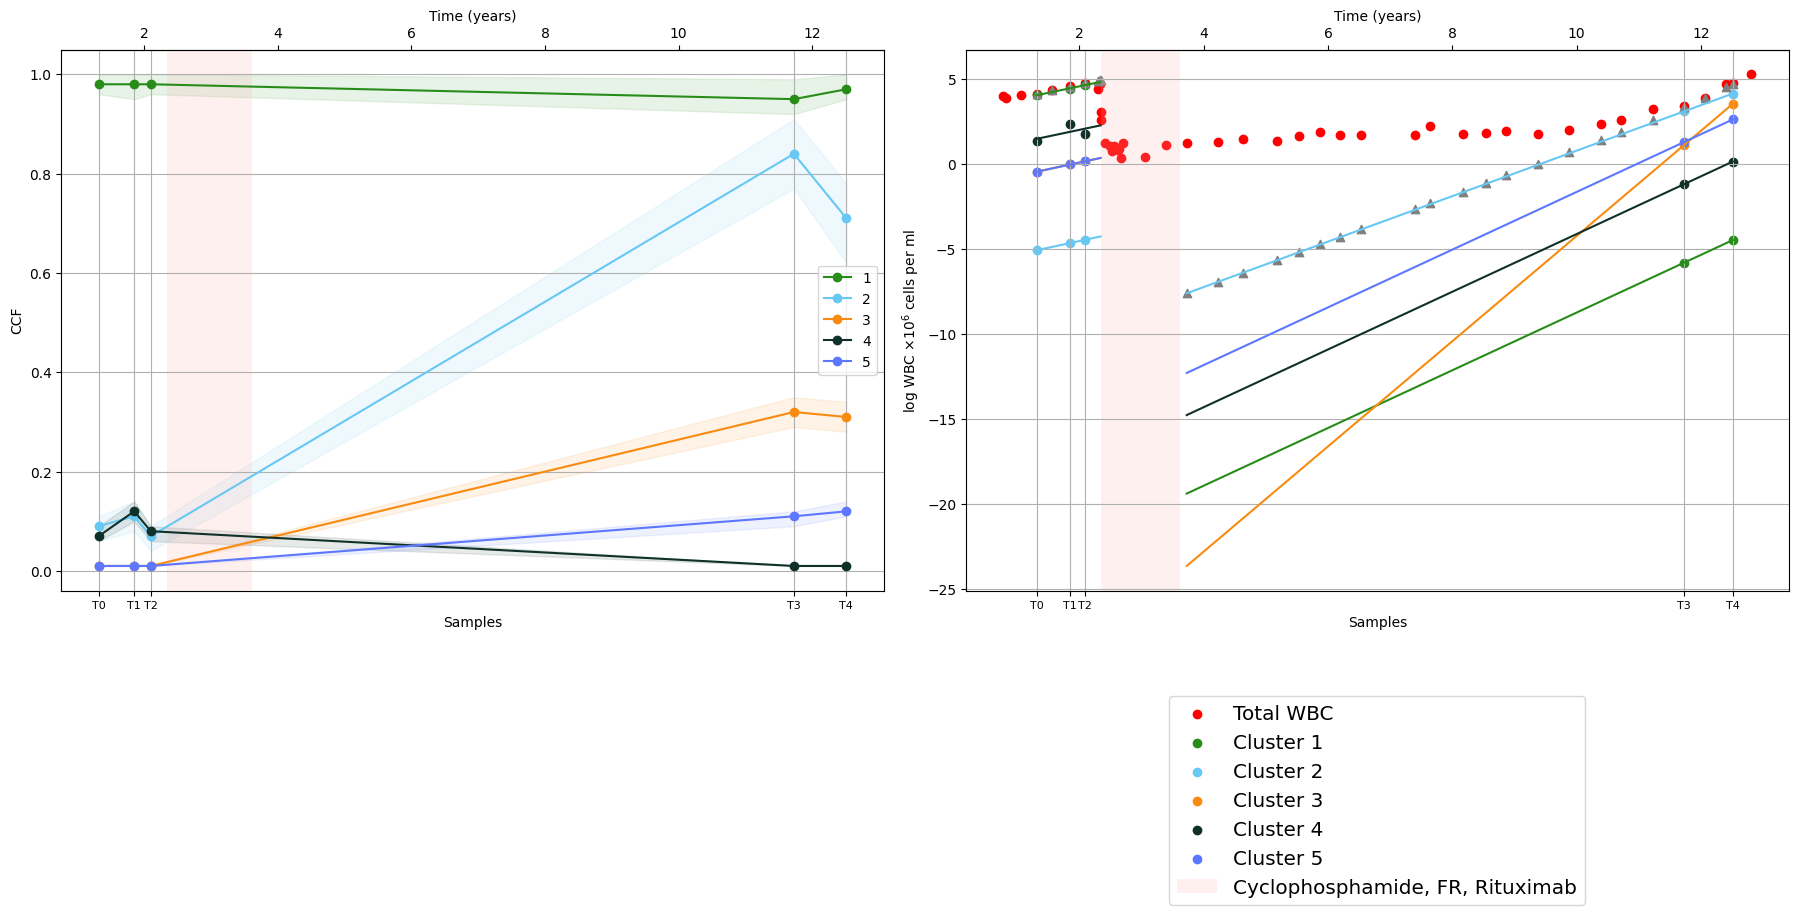

In [108]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_sub(ax, clusters):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}
    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))


        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            



    
    cluster_cell_population = {}
    for i in clusters:
         # Extrapolate before treatment 

        extrapolate_times =[times_sample[0], times_sample[1], times_sample[2]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][0], log_subclone_sample[i][1], log_subclone_sample[i][2]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_bf
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))

        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential
    
    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    # add potential UMI samples
    # ax.axvline(x=952/365,  color = 'red')
    # ax.axvline(x=1012/365, label ='UMI',color = 'red')

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_sub(ax2, [1,2,3, 4,5])
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [19]:
# Linear Regression Modeling

In [109]:
from scipy.special import logsumexp 
from scipy.optimize import minimize

In [110]:
class MultiClusterLinearRegression:
    def __init__(self, n_clusters,X, y):
        self.n_clusters = n_clusters
        self.params = None
        self.X = X
        self.y = y
        
        
    def calculate_weight_ratio(self ):
        num_wbc = len(self.y)
        num_exomes = sum(1 for item in self.y if item is not None)
        
        weight_ratio = num_wbc / ((num_exomes)*(self.n_clusters -1))
        return weight_ratio
        

    def objective(self, params, logsumexp_points, ):
        # reshape params into intercepts and slopes
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]

        weight_ratio = self.calculate_weight_ratio()
        
        # calculate predicted y values for all clusters 
        y_pred = np.outer(self.X, slopes) + intercepts

        # Calcualte negative log-likelihood
        likelihood = 0

        # For exome points
        for i, yi in enumerate(self.y):
   
            if yi is not None:
                likelihood +=  weight_ratio * np.sum((yi - y_pred[i])**2)

        # For logsumexp points
        
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood += (lse - logsumexp(y_pred[i]))**2

        return likelihood  # We minimize negative log-likelihood



    def fit(self, logsumexp_points, initial_guess = None):

        if initial_guess is None:
            initial_guess = np.random.randn(2 * self.n_clusters)

        result = minimize(
            self.objective, 
            initial_guess,
            args = (logsumexp_points),
            method = 'SLSQP'
        )

        self.params = result.x 




        
        
    def calculate_likelihood(self, params, logsumexp_points):
        intercepts = params[:self.n_clusters]
        slopes = params[self.n_clusters:]
        y_pred = np.outer(self.X, slopes) + intercepts
        
        likelihood_y = 0
        for i, yi in enumerate(self.y):
            if yi is not None:
                likelihood_y += np.sum((yi - y_pred[i])**2)
                print(f"exome logsubclone: {yi},exome predicted: {y_pred[i]}, likelihood_y: {likelihood_y}")
        
       
        print(f"squared sum_y: {likelihood_y}")
        
        
        likelihood_logsumexp = 0 
        for i, lse in enumerate(logsumexp_points):
            if lse is not None:
                likelihood_logsumexp += (lse - logsumexp(y_pred[i]))**2
                print(f"log wbc: {lse},wbc predicted: {logsumexp(y_pred[i])}")
        print(f"squared sum_logsumexp: {likelihood_logsumexp}")
        
        total_squared_sum = likelihood_y + likelihood_logsumexp
    
        print(f"total squared sum: {total_squared_sum}")
        return likelihood_y, likelihood_logsumexp
    


    def predict(self,):
        intercepts = self.params[:self.n_clusters]
        slopes = self.params[self.n_clusters:]
        return np.outer(self.X, slopes) + intercepts
    


In [21]:
# Try the model on real data

In [111]:
def create_inputs(times_sliced, log_subclone_sample_mcmc,iter, index_samples_model):
    
    X = [ i/365 for i in np.array(times_sliced)]
    
    
    # reconstruct the dictionary so that {iteration number: cluster number :[time]}
    log_subclone_cluster_iter = {}
    
    # Iterate through each cluster
    for cluster, iterations in log_subclone_sample_mcmc.items():
        # Iterate through each iteration in the cluster
        for iteration, value in iterations.items():
            # If the iteration is not in the new dict, add it
            if iteration not in log_subclone_cluster_iter:
                log_subclone_cluster_iter[iteration] = {}
            # Add the cluster and its value to this iteration
            log_subclone_cluster_iter[iteration][cluster] = value
    
    
    
    values = list(log_subclone_cluster_iter[iter].values())
    array = np.array(values)
    array_trans = array.T
    selected_sample = array_trans[index_samples_model]
    
    
    times_sample_selected = times_sample[index_samples_model]
    indices = [i for i, x in enumerate(times_sliced) if x in times_sample_selected]
    
    y = [None] * len(times_sliced)
    i = 0
    # Fill the rows that correspond with the exome points
    for index in indices: 
        y[index] = selected_sample[i]
        i +=1
    
    
    return X, y
    
    
    

In [112]:
n_clusters = 5

X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,7, slice(3,5))

logsumexp_points = np.log(wbc_sliced_aft)

In [114]:
model = MultiClusterLinearRegression(n_clusters, X, y)
model.fit(logsumexp_points)

In [115]:
model.params[n_clusters:]

array([1.65829617, 1.51733432, 2.30425872, 1.65761433, 0.07536392])

In [116]:
model.calculate_weight_ratio()

2.75

In [117]:
model.calculate_likelihood(model.params, logsumexp_points)

exome logsubclone: [-1.59106874  3.09021748  1.34957608 -0.9494834   1.30474603],exome predicted: [-1.59083154  3.13369699  1.35197892 -0.94887032  2.02119149], likelihood_y: 0.5151907771050218
exome logsubclone: [-0.28710874  4.31965     3.15460365  0.35425779  2.60826944],exome predicted: [-0.28691099  4.32677904  3.1638207   0.3545141   2.08045024], likelihood_y: 0.7939197658513167
squared sum_y: 0.7939197658513167
log wbc: 1.252762968495368,wbc predicted: 1.4187233506582002
log wbc: 1.2809338454620642,wbc predicted: 1.4563339280680265
log wbc: 1.4586150226995167,wbc predicted: 1.4867349286255496
log wbc: 1.3609765531356006,wbc predicted: 1.5285790340599832
log wbc: 1.62924053973028,wbc predicted: 1.5547546315334786
log wbc: 1.8562979903656263,wbc predicted: 1.5810333909852483
log wbc: 1.7227665977411035,wbc predicted: 1.6060065961560643
log wbc: 1.7047480922384253,wbc predicted: 1.6312219775126242
log wbc: 1.6863989535702288,wbc predicted: 1.7007460821597966
log wbc: 2.208274413522

(np.float64(0.7939197658513167), np.float64(0.614916484411683))

In [118]:
print("Estimated parameters:")
print("Intercepts:", model.params[:n_clusters])
print("Slopes:", model.params[n_clusters:])

Estimated parameters:
Intercepts: [-21.03151458 -14.65444971 -25.66150888 -20.38155999   1.13767863]
Slopes: [1.65829617 1.51733432 2.30425872 1.65761433 0.07536392]


In [119]:


logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]


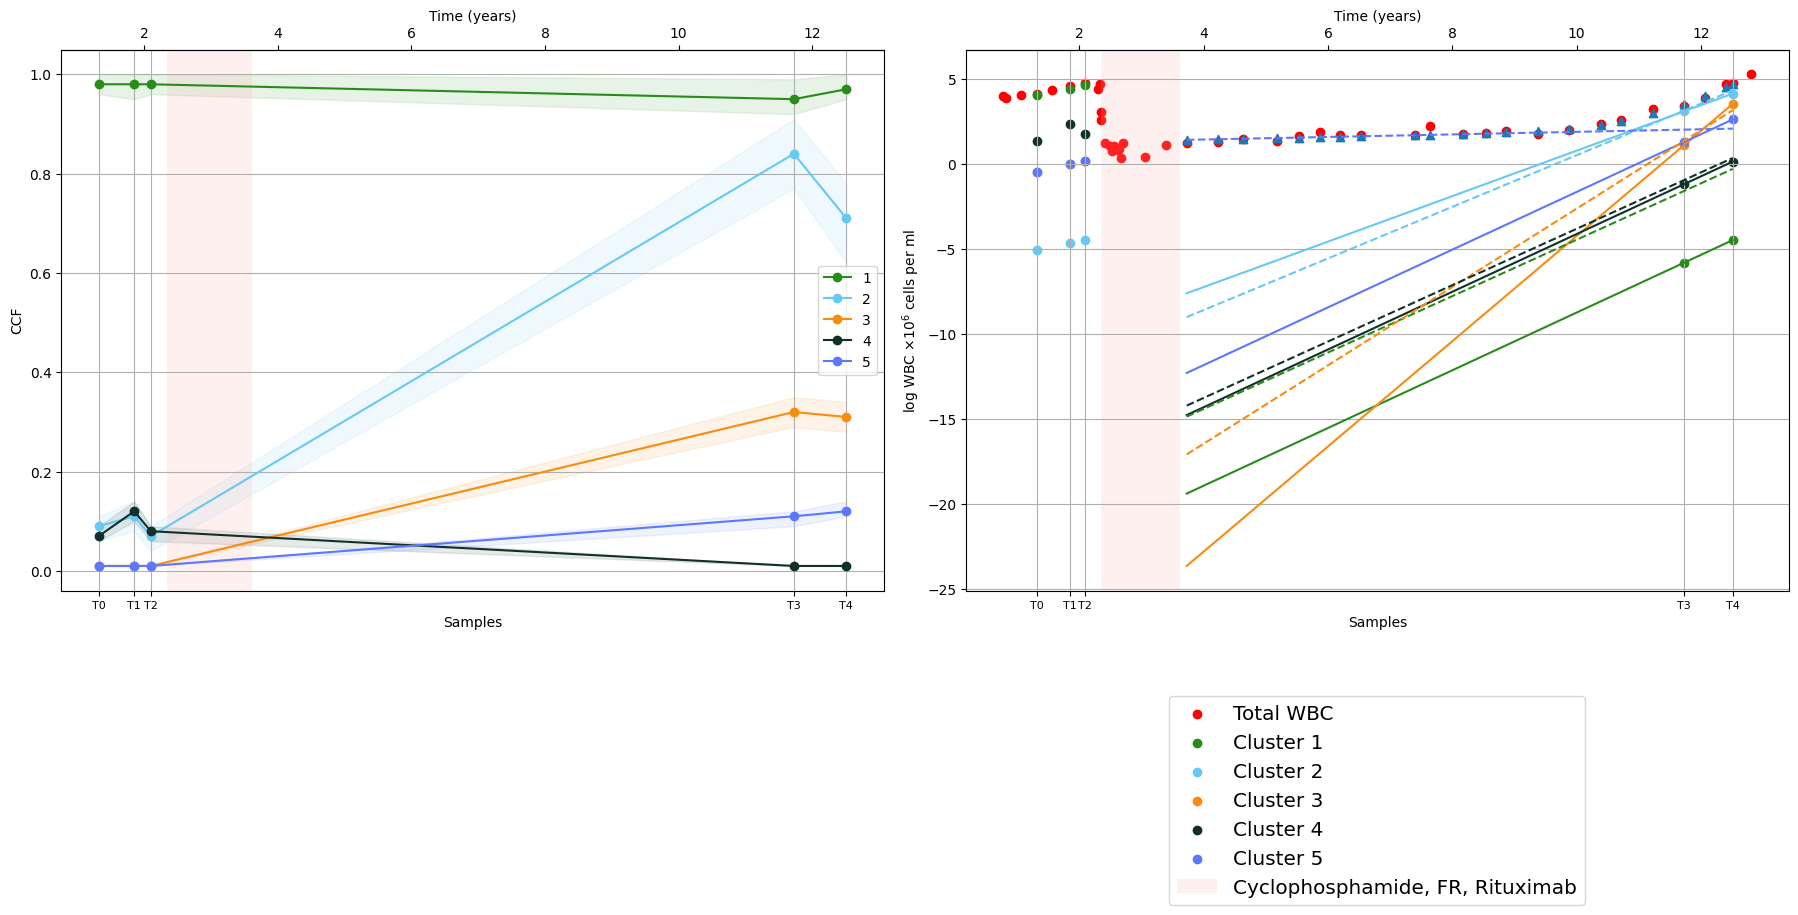

In [120]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')
    
    
    
    

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_model_single_iter(ax2, [1,2,3, 4,5], model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4,5]:

    ax2.plot(X,model.predict()[:,i-1], '--', color=ClusterColors.get_hex_string(i))
ax2.scatter(X, logsumexp_points_model,marker='^')

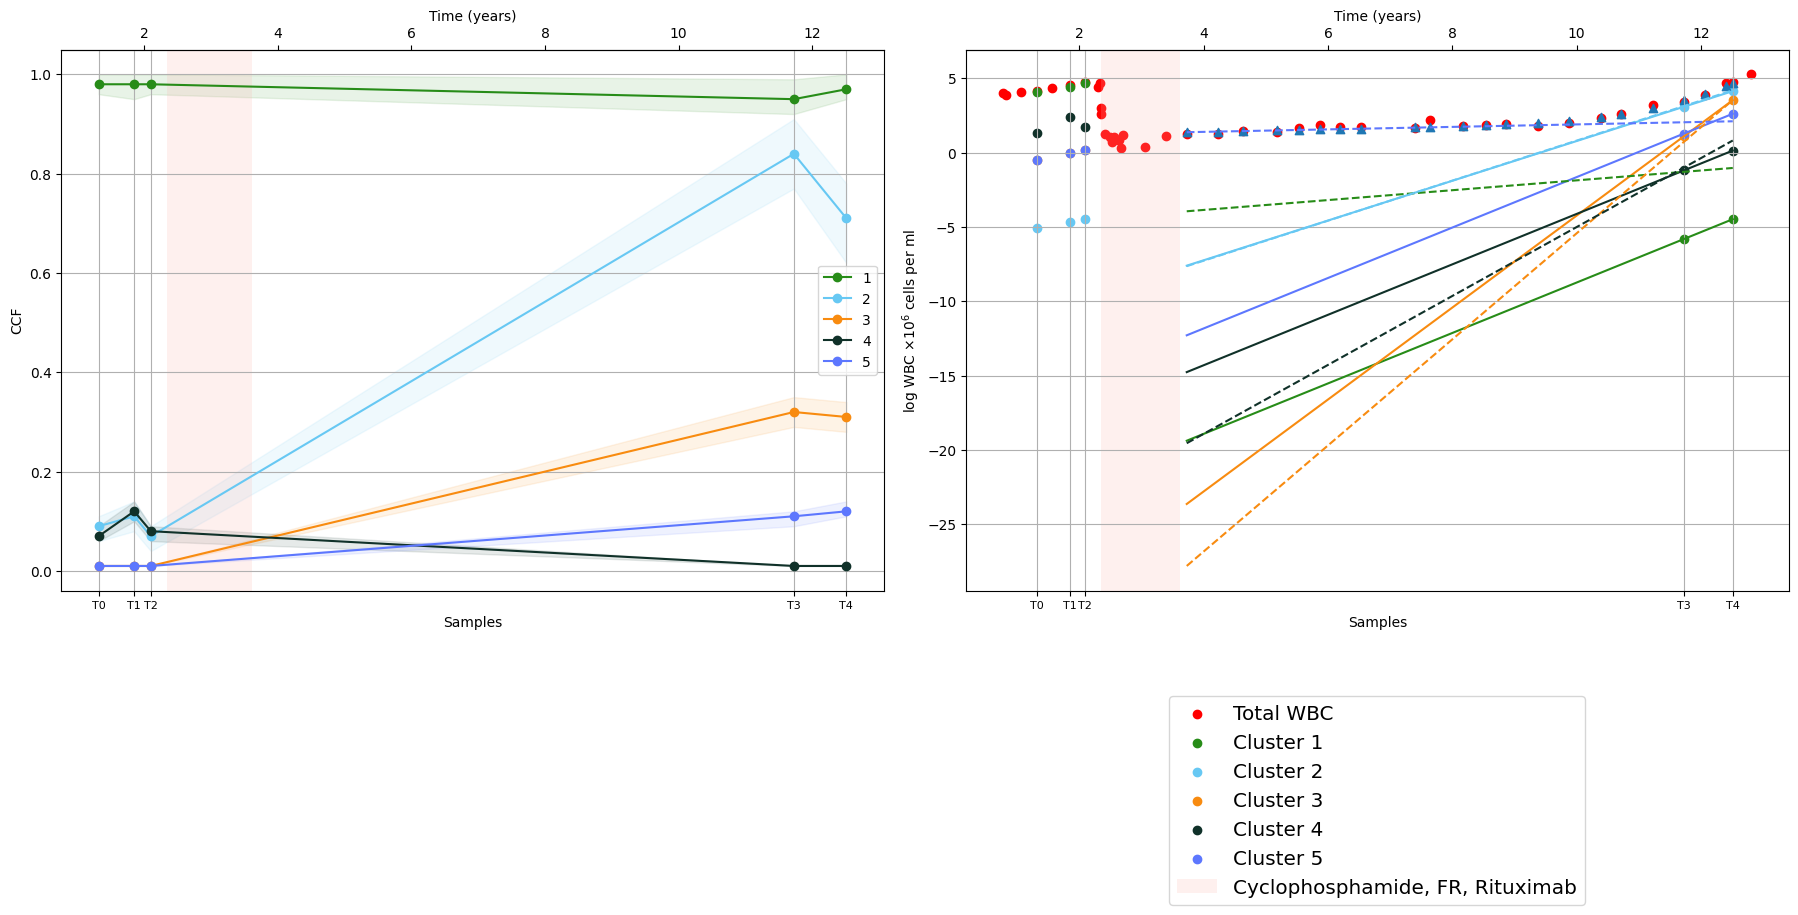

In [48]:
fig,(ax1, ax2) = plt.subplots(1,2, figsize=(18,6))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


def plot_model_single_iter(ax, clusters, model):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    cluster_cell_population = {}

    
    for i in clusters:
        x_year = [ i/365 for i in np.array(times_sample)]
        y_sub = np.array(log_subclone_sample[i])
        ax.scatter(x_year,y_sub, label = f'Cluster {i}',c= ClusterColors.get_hex_string(i),)


        # Extrapolate after treatment
        extrapolate_times =[times_sample[3], times_sample[4]]
        extrapolate_year = [ i/365 for i in np.array(extrapolate_times)]
        extrapolate_subclone = [log_subclone_sample[i][3], log_subclone_sample[i][4]]

        model = np.polyfit(extrapolate_year, extrapolate_subclone, 1)

        predict_x = times_sliced_aft
 
        predict_year = [ i/365 for i in np.array(predict_x)]
        predicted = np.polyval(model, predict_year)
        plt.plot(predict_year, predicted, color=ClusterColors.get_hex_string(i))



        natural_exponential = [ np.exp(i) for i in predicted]
        cluster_cell_population[i] = natural_exponential

    predicted_total = []
    for timepoint in range(len(predict_year)):
        predicted_wbc = 0
        for cluster in cluster_cell_population:
            predicted_wbc += cluster_cell_population[cluster][timepoint]
        predicted_total.append(predicted_wbc)
        
    # convert back to log scale
    predicted_total_log = [np.log(i) for i in predicted_total]
    
    # plt.scatter(predict_year, predicted_total_log, color='grey',marker='^', alpha = 1)
            

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')
    
    
    
    

model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_model_single_iter(ax2, [1,2,3, 4,5], model)
ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')


for i in [1,2,3,4,5]:

    ax2.plot(X,model.predict()[:,i-1], '--', color=ClusterColors.get_hex_string(i))
ax2.scatter(X, logsumexp_points_model,marker='^')

In [292]:
# Add in mcmc iterations

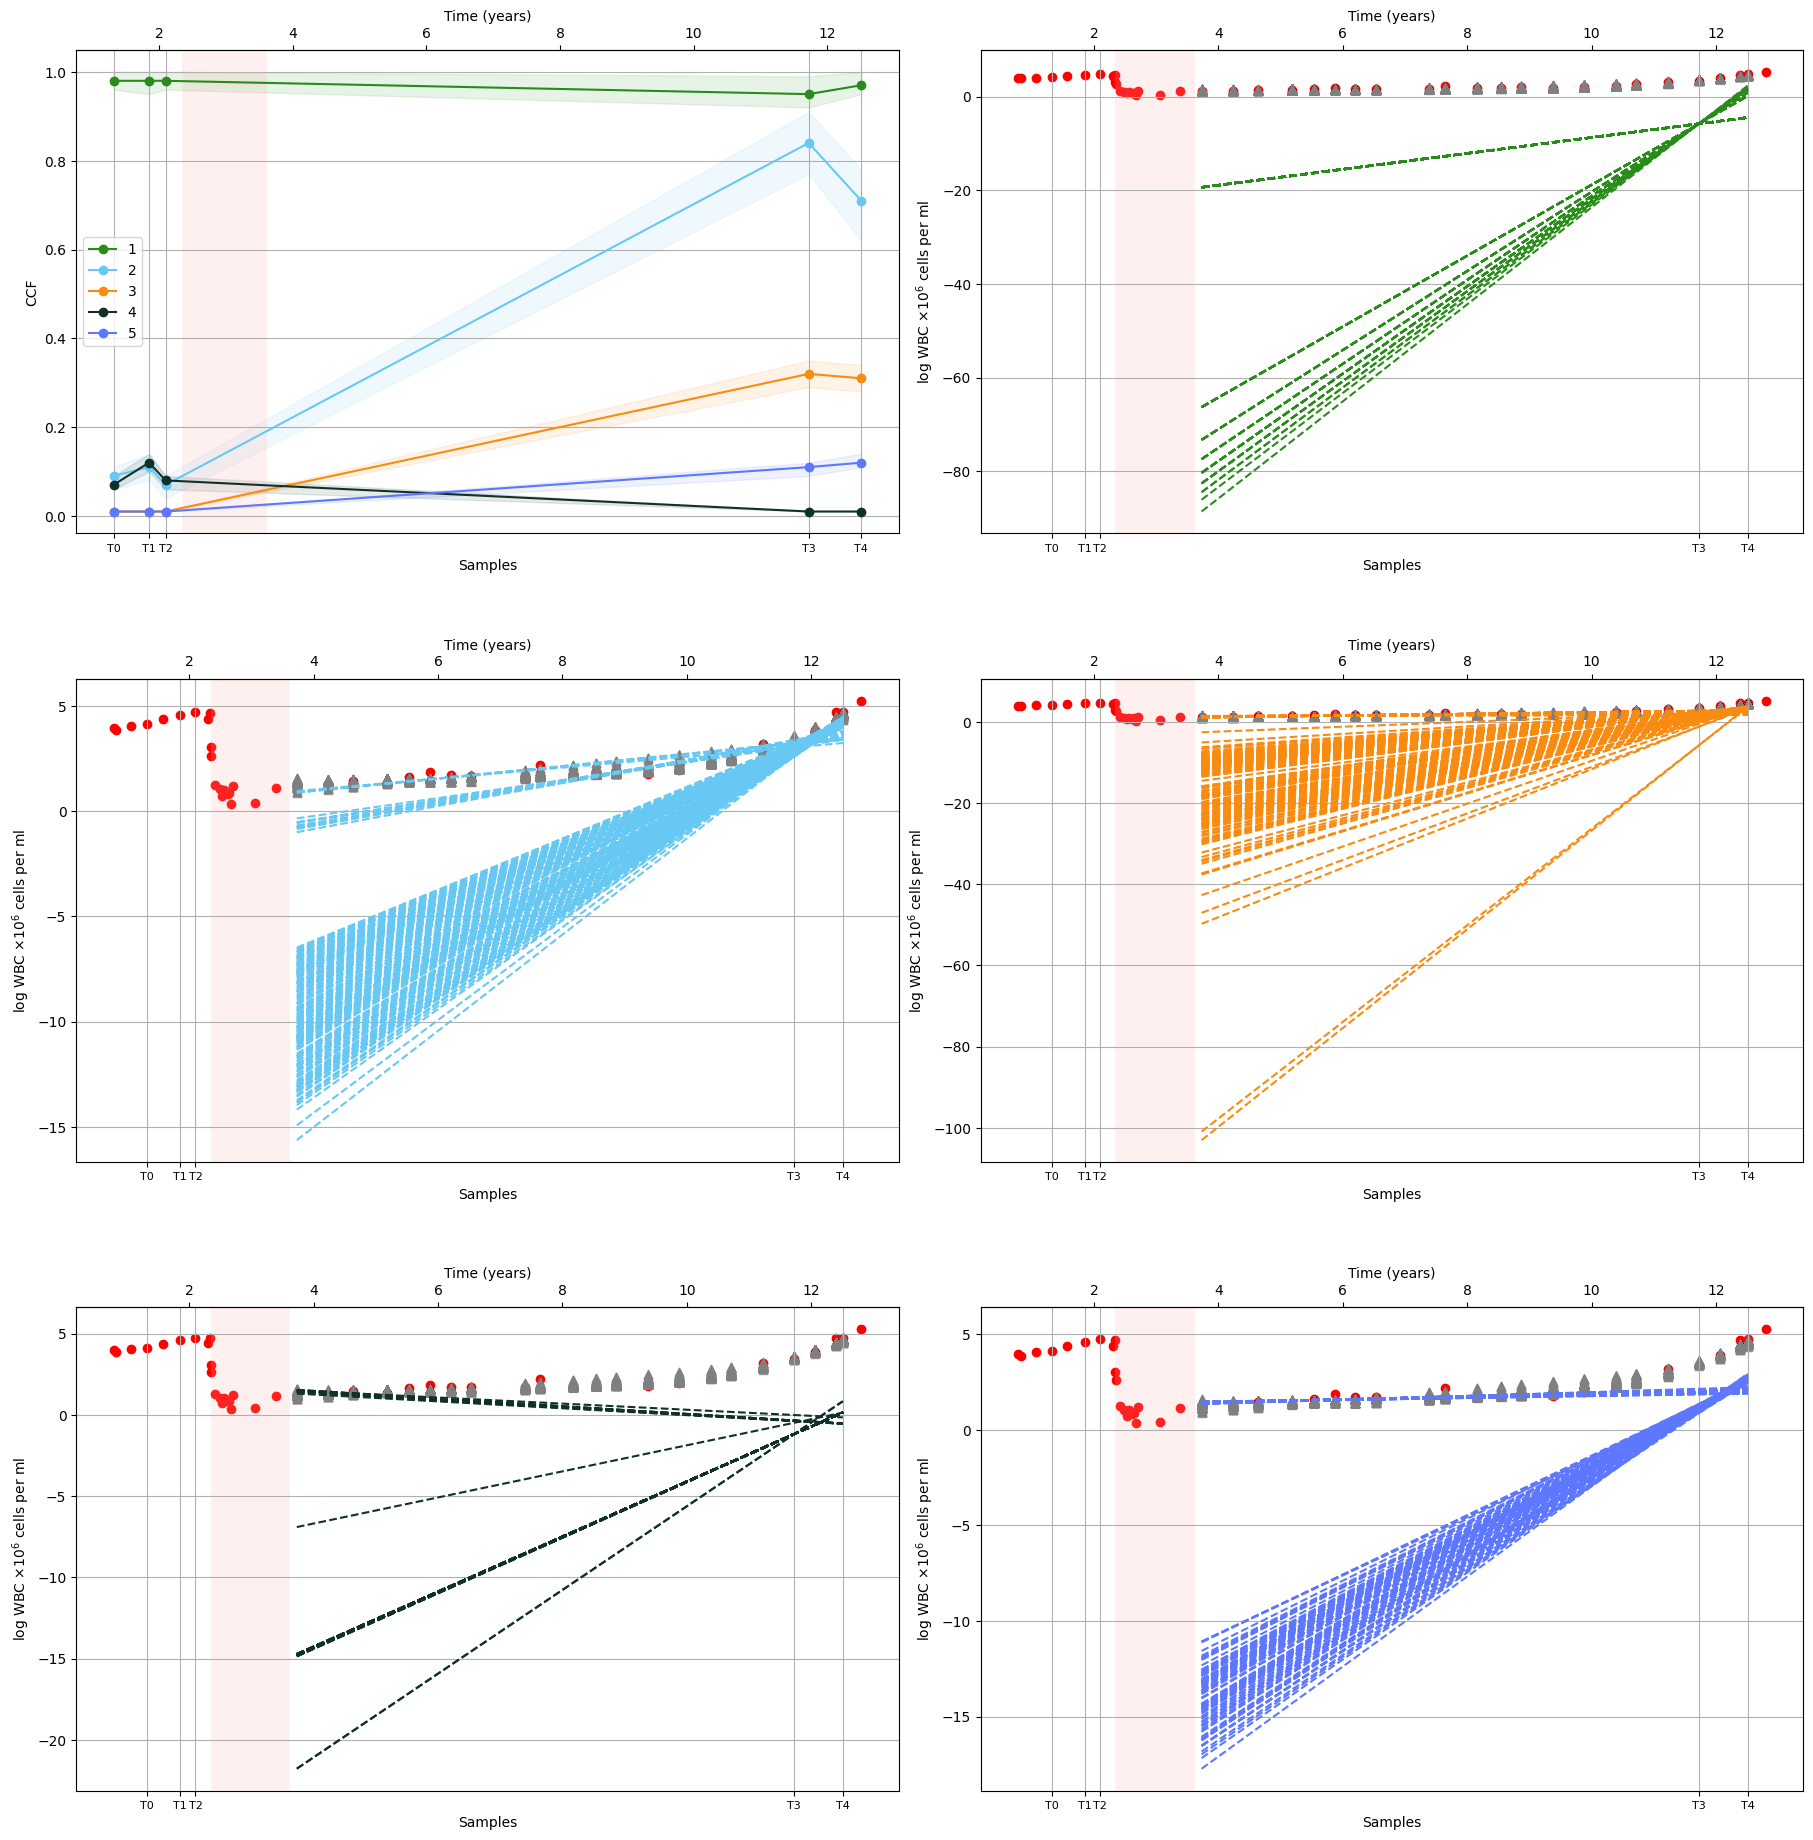

In [121]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
    
    for iter_idx in range(250):
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(wbc_sliced_aft)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)

        
        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  


        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax3, 2, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax4, 3, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax5, 4, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax6, 5, n_clusters = 5, index_samples_model = slice(3,5), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')





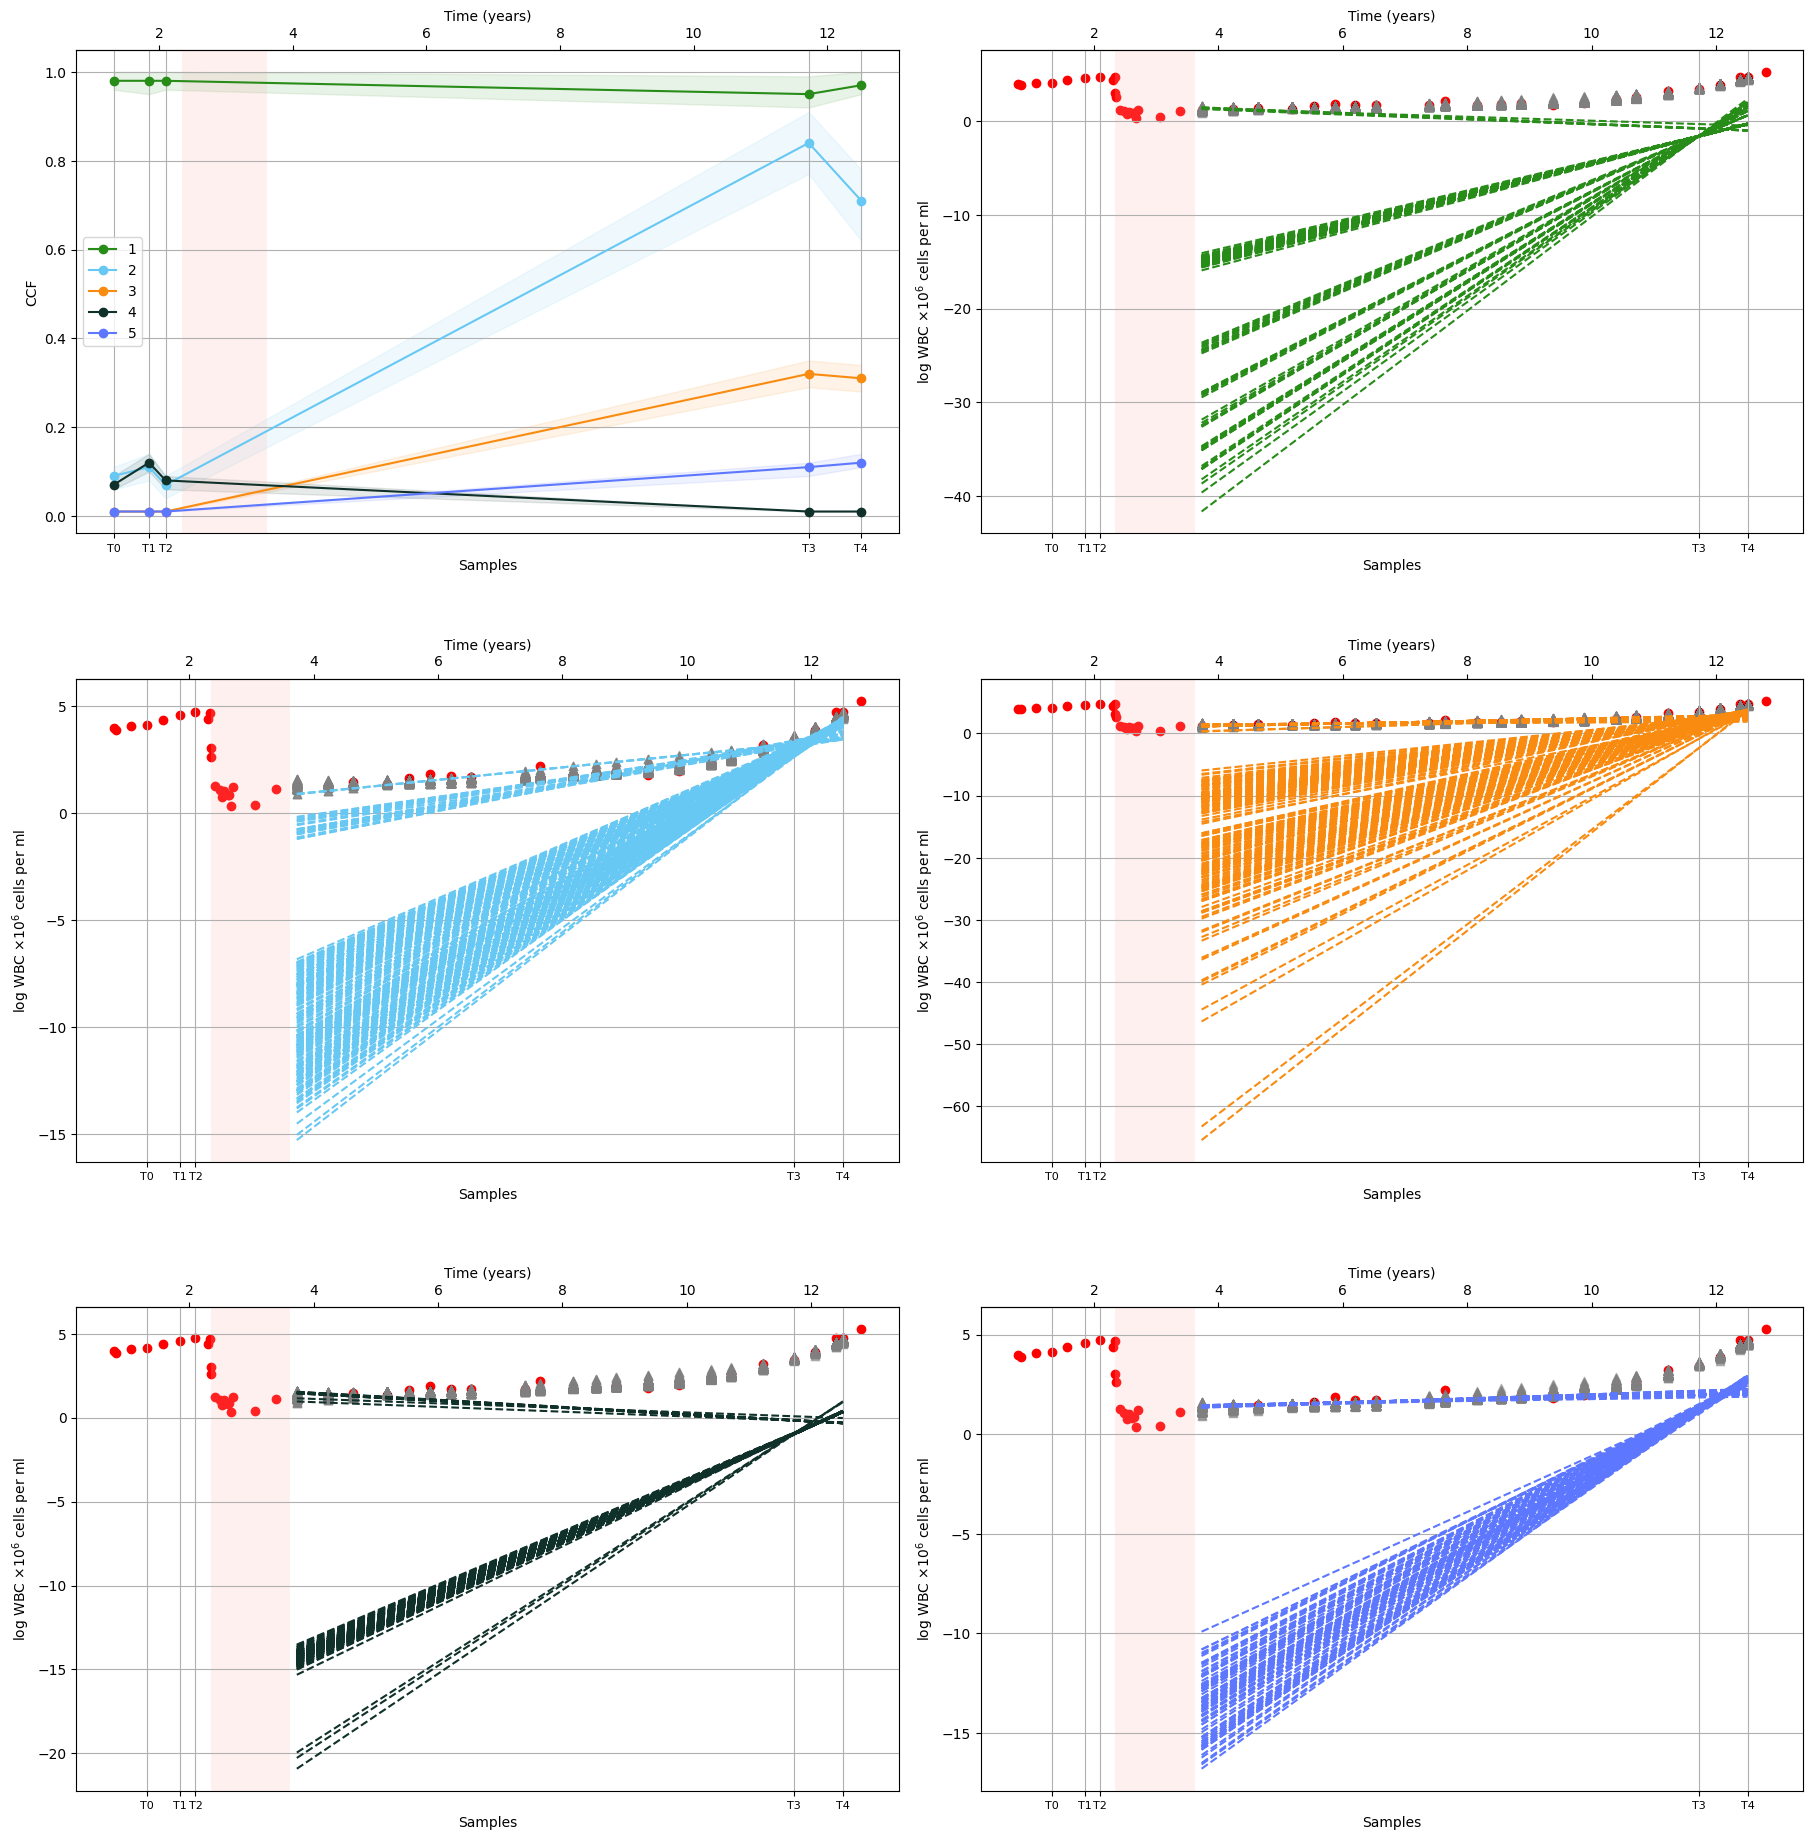

In [122]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]



slopes_mcmc = {}
def plot_mcmc_model(ax, cluster, n_clusters,index_samples_model, ):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    # store the weights in a dictionary 
    
    
    for iter_idx in range(250):
        
        X, y = create_inputs(times_sliced_aft, log_subclone_sample_mcmc_with_uniform_noise,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(wbc_sliced_aft)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)

        
        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc[iter_idx] = model.params[n_clusters:]  


        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')

    


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, 1, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax3, 2, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax4, 3, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax5, 4, n_clusters = 5, index_samples_model = slice(3,5), )
plot_mcmc_model(ax6, 5, n_clusters = 5, index_samples_model = slice(3,5), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')





In [124]:
all_abundance[5]

{0: [0.01, 0.01, 0.0, 0.12, 0.13],
 1: [0.01, 0.0, 0.01, 0.12, 0.13],
 2: [0.0, 0.01, 0.0, 0.11, 0.13],
 3: [0.0, 0.0, 0.01, 0.11, 0.12],
 4: [0.01, 0.01, 0.0, 0.12, 0.12],
 5: [0.0, 0.0, 0.01, 0.11, 0.11],
 6: [0.01, 0.0, 0.01, 0.11, 0.12],
 7: [0.01, 0.01, 0.01, 0.11, 0.11],
 8: [0.0, 0.01, 0.0, 0.11, 0.13],
 9: [0.01, 0.0, 0.01, 0.12, 0.1],
 10: [0.01, 0.01, 0.01, 0.1, 0.13],
 11: [0.01, 0.01, 0.01, 0.1, 0.1],
 12: [0.0, 0.01, 0.0, 0.11, 0.1],
 13: [0.0, 0.0, 0.01, 0.09, 0.12],
 14: [0.01, 0.01, 0.0, 0.12, 0.12],
 15: [0.01, 0.01, 0.01, 0.1, 0.13],
 16: [0.01, 0.01, 0.0, 0.1, 0.13],
 17: [0.01, 0.0, 0.0, 0.11, 0.12],
 18: [0.01, 0.01, 0.0, 0.11, 0.11],
 19: [0.01, 0.01, 0.0, 0.1, 0.12],
 20: [0.01, 0.0, 0.01, 0.12, 0.15],
 21: [0.01, 0.0, 0.0, 0.11, 0.11],
 22: [0.01, 0.0, 0.01, 0.11, 0.12],
 23: [0.01, 0.01, 0.01, 0.13, 0.12],
 24: [0.01, 0.01, 0.0, 0.12, 0.09],
 25: [0.01, 0.01, 0.01, 0.13, 0.12],
 26: [0.01, 0.01, 0.0, 0.12, 0.13],
 27: [0.01, 0.01, 0.0, 0.11, 0.12],
 28: [0.01, 

In [125]:
noise_added_original_all_abundances[5]

{0: [0.017041076733202792,
  0.01738224233738954,
  0.007227452070609775,
  0.13144048599693986,
  0.14474809715719586],
 1: [0.01738224233738954,
  0.007227452070609775,
  0.01755799958650661,
  0.13144048599693986,
  0.13614060548791554],
 2: [0.007227452070609775,
  0.01792039698213971,
  0.007299082526910162,
  0.11988328146979105,
  0.13889372535004277],
 3: [0.007299082526910162,
  0.007299082526910162,
  0.017041076733202792,
  0.12112047790468532,
  0.1300978748754402],
 4: [0.017041076733202792,
  0.01773734741329933,
  0.007299082526910162,
  0.13421059484670853,
  0.13421059484670853],
 5: [0.007227452070609775,
  0.00752275400765016,
  0.017209968908525962,
  0.12112047790468532,
  0.11867110438945343],
 6: [0.01755799958650661,
  0.0074466891062119275,
  0.01755799958650661,
  0.12112047790468532,
  0.12749329062409342],
 7: [0.01738224233738954,
  0.01755799958650661,
  0.017041076733202792,
  0.12238347637119429,
  0.11867110438945343],
 8: [0.007299082526910162,
  0.017

In [130]:
[i[3:] for i in all_abundance[5].values()]

[[0.12, 0.13],
 [0.12, 0.13],
 [0.11, 0.13],
 [0.11, 0.12],
 [0.12, 0.12],
 [0.11, 0.11],
 [0.11, 0.12],
 [0.11, 0.11],
 [0.11, 0.13],
 [0.12, 0.1],
 [0.1, 0.13],
 [0.1, 0.1],
 [0.11, 0.1],
 [0.09, 0.12],
 [0.12, 0.12],
 [0.1, 0.13],
 [0.1, 0.13],
 [0.11, 0.12],
 [0.11, 0.11],
 [0.1, 0.12],
 [0.12, 0.15],
 [0.11, 0.11],
 [0.11, 0.12],
 [0.13, 0.12],
 [0.12, 0.09],
 [0.13, 0.12],
 [0.12, 0.13],
 [0.11, 0.12],
 [0.12, 0.12],
 [0.11, 0.11],
 [0.12, 0.12],
 [0.1, 0.13],
 [0.12, 0.1],
 [0.12, 0.1],
 [0.08, 0.1],
 [0.11, 0.12],
 [0.11, 0.12],
 [0.11, 0.11],
 [0.11, 0.11],
 [0.1, 0.12],
 [0.09, 0.14],
 [0.12, 0.12],
 [0.1, 0.12],
 [0.11, 0.12],
 [0.11, 0.12],
 [0.11, 0.15],
 [0.13, 0.12],
 [0.1, 0.11],
 [0.12, 0.13],
 [0.09, 0.1],
 [0.1, 0.14],
 [0.11, 0.12],
 [0.1, 0.12],
 [0.09, 0.13],
 [0.1, 0.14],
 [0.11, 0.12],
 [0.14, 0.13],
 [0.1, 0.1],
 [0.08, 0.13],
 [0.12, 0.13],
 [0.09, 0.13],
 [0.13, 0.12],
 [0.1, 0.13],
 [0.1, 0.12],
 [0.12, 0.12],
 [0.12, 0.11],
 [0.12, 0.15],
 [0.12, 0.11],
 [0

In [127]:
[i[3:] for i in noise_added_original_all_abundances[5].values()]

[[0.13144048599693986, 0.14474809715719586],
 [0.13144048599693986, 0.13614060548791554],
 [0.11988328146979105, 0.13889372535004277],
 [0.12112047790468532, 0.1300978748754402],
 [0.13421059484670853, 0.13421059484670853],
 [0.12112047790468532, 0.11867110438945343],
 [0.12112047790468532, 0.12749329062409342],
 [0.12238347637119429, 0.11867110438945343],
 [0.12112047790468532, 0.13614060548791554],
 [0.1300978748754402, 0.10536369869653994],
 [0.10855979390915875, 0.14031246828108937],
 [0.11434045301354631, 0.11080046981243076],
 [0.12633561623210654, 0.11080046981243075],
 [0.10152823391577935, 0.1300978748754402],
 [0.1300978748754402, 0.12749329062409342],
 [0.11313559022573388, 0.13750338592288472],
 [0.11195585514348683, 0.13750338592288472],
 [0.12238347637119429, 0.12749329062409345],
 [0.11517732335913294, 0.11748319532530219],
 [0.11195585514348681, 0.12499094802172594],
 [0.13144048599693986, 0.154431822009505],
 [0.12367309253622122, 0.11988328146979105],
 [0.118671104389

In [131]:
slopes_mcmc 

{0: array([1.72365165, 1.47360909, 2.85386106, 1.72433396, 0.09307388]),
 1: array([1.64647818, 1.39305383, 2.92214411, 1.64712159, 0.08833532]),
 2: array([1.68508843, 1.34027985, 3.66291645, 1.68565223, 0.08366506]),
 3: array([3.88558686, 1.59721746, 0.15803517, 1.69027273, 1.83849845]),
 4: array([1.70095041, 1.90640659, 0.19985971, 1.70442614, 1.76815917]),
 5: array([1.67127475, 1.40455132, 2.70375338, 1.67155928, 0.07392832]),
 6: array([1.65971756, 1.59908509, 1.7597638 , 1.65791969, 0.08051969]),
 7: array([1.65966683, 1.68593647, 0.11645412, 1.66117306, 1.6797483 ]),
 8: array([1.64611476, 1.78323063, 1.45617004, 1.64559344, 0.08494534]),
 9: array([3.43777737, 2.05068277, 0.20376506, 1.65395331, 1.51853403]),
 10: array([1.71011357, 1.3837292 , 2.34784372, 1.71040666, 0.07945928]),
 11: array([1.66167529, 1.95967926, 0.20480293, 1.66512479, 1.7217552 ]),
 12: array([4.15386039, 2.00481923, 0.20032525, 1.65127395, 1.60370966]),
 13: array([1.6746364 , 1.93154087, 0.20072858, 

In [132]:
[i[:] for i in slopes_mcmc.values()]

[array([1.72365165, 1.47360909, 2.85386106, 1.72433396, 0.09307388]),
 array([1.64647818, 1.39305383, 2.92214411, 1.64712159, 0.08833532]),
 array([1.68508843, 1.34027985, 3.66291645, 1.68565223, 0.08366506]),
 array([3.88558686, 1.59721746, 0.15803517, 1.69027273, 1.83849845]),
 array([1.70095041, 1.90640659, 0.19985971, 1.70442614, 1.76815917]),
 array([1.67127475, 1.40455132, 2.70375338, 1.67155928, 0.07392832]),
 array([1.65971756, 1.59908509, 1.7597638 , 1.65791969, 0.08051969]),
 array([1.65966683, 1.68593647, 0.11645412, 1.66117306, 1.6797483 ]),
 array([1.64611476, 1.78323063, 1.45617004, 1.64559344, 0.08494534]),
 array([3.43777737, 2.05068277, 0.20376506, 1.65395331, 1.51853403]),
 array([1.71011357, 1.3837292 , 2.34784372, 1.71040666, 0.07945928]),
 array([1.66167529, 1.95967926, 0.20480293, 1.66512479, 1.7217552 ]),
 array([4.15386039, 2.00481923, 0.20032525, 1.65127395, 1.60370966]),
 array([1.6746364 , 1.93154087, 0.20072858, 1.67798457, 2.05131648]),
 array([1.67168198, 

In [37]:
# Convert dictionary values to a numpy array
data = np.array(list(slopes_mcmc.values()))

# Calculate mean and 95% confidence interval for each column (first, second, third, fourth)
means = np.mean(data, axis=0)
lower_ci = np.percentile(data, 2.5, axis=0)
upper_ci = np.percentile(data, 97.5, axis=0)

for i in range(5):
    print(f"Cluster {i+1}:")
    print(f"  Mean: {means[i]:.4f}")
    print(f"  95% Confidence Interval: {lower_ci[i]:.4f} to {upper_ci[i]:.4f}\n")


Cluster 1:
  Mean: 2.1578
  95% Confidence Interval: -0.3174 to 5.7009

Cluster 2:
  Mean: 1.4711
  95% Confidence Interval: 0.2817 to 2.0518

Cluster 3:
  Mean: 1.7935
  95% Confidence Interval: 0.1179 to 4.6376

Cluster 4:
  Mean: 1.5230
  95% Confidence Interval: -0.1832 to 2.3366

Cluster 5:
  Mean: 0.8313
  95% Confidence Interval: 0.0622 to 2.1755



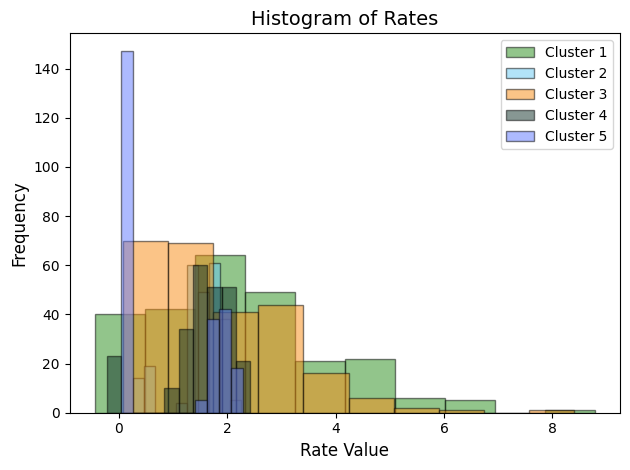

In [39]:
# Plot the histogram for each rate (first, second, third, fourth)
# plt.hist(data[:, 0], bins=10, alpha=0.5, label='First Rate', color='blue', edgecolor='black')

for i in range(5):
    plt.hist(data[:, i], bins=10, alpha=0.5, label=f'Cluster {i+1}', color=ClusterColors.get_hex_string(i+1), edgecolor='black')

# Add title and labels
plt.title('Histogram of Rates', fontsize=14)
plt.xlabel('Rate Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add legend to differentiate the rates
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
    

In [56]:
all_abundance[1]

{0: [0.92, 0.85, 0.93, 0.0, 0.0],
 1: [0.87, 0.88, 0.88, 0.0, 0.0],
 2: [0.91, 0.84, 0.9, 0.0, 0.0],
 3: [0.91, 0.86, 0.95, 0.0, 0.03],
 4: [0.89, 0.82, 0.91, 0.0, 0.0],
 5: [0.93, 0.84, 0.93, 0.0, 0.0],
 6: [0.91, 0.86, 0.88, 0.0, 0.0],
 7: [0.89, 0.87, 0.92, 0.0, 0.0],
 8: [0.91, 0.83, 0.92, 0.0, 0.0],
 9: [0.87, 0.88, 0.89, 0.0, 0.02],
 10: [0.91, 0.87, 0.92, 0.0, 0.0],
 11: [0.9, 0.89, 0.88, 0.0, 0.0],
 12: [0.88, 0.78, 0.91, 0.0, 0.04],
 13: [0.9, 0.85, 0.87, 0.0, 0.0],
 14: [0.86, 0.86, 0.92, 0.0, 0.0],
 15: [0.9, 0.85, 0.88, 0.0, 0.0],
 16: [0.9, 0.86, 0.93, 0.0, 0.0],
 17: [0.87, 0.86, 0.91, 0.0, 0.0],
 18: [0.88, 0.81, 0.93, 0.0, 0.0],
 19: [0.82, 0.79, 0.89, 0.0, 0.0],
 20: [0.89, 0.85, 0.89, 0.0, 0.0],
 21: [0.91, 0.85, 0.88, 0.0, 0.0],
 22: [0.89, 0.87, 0.92, 0.0, 0.01],
 23: [0.9, 0.88, 0.86, 0.0, 0.0],
 24: [0.89, 0.86, 0.92, 0.0, 0.0],
 25: [0.9, 0.83, 0.94, 0.0, 0.0],
 26: [0.88, 0.88, 0.92, 0.0, 0.0],
 27: [0.89, 0.85, 0.9, 0.0, 0.0],
 28: [0.9, 0.85, 0.91, 0.0, 0.0],


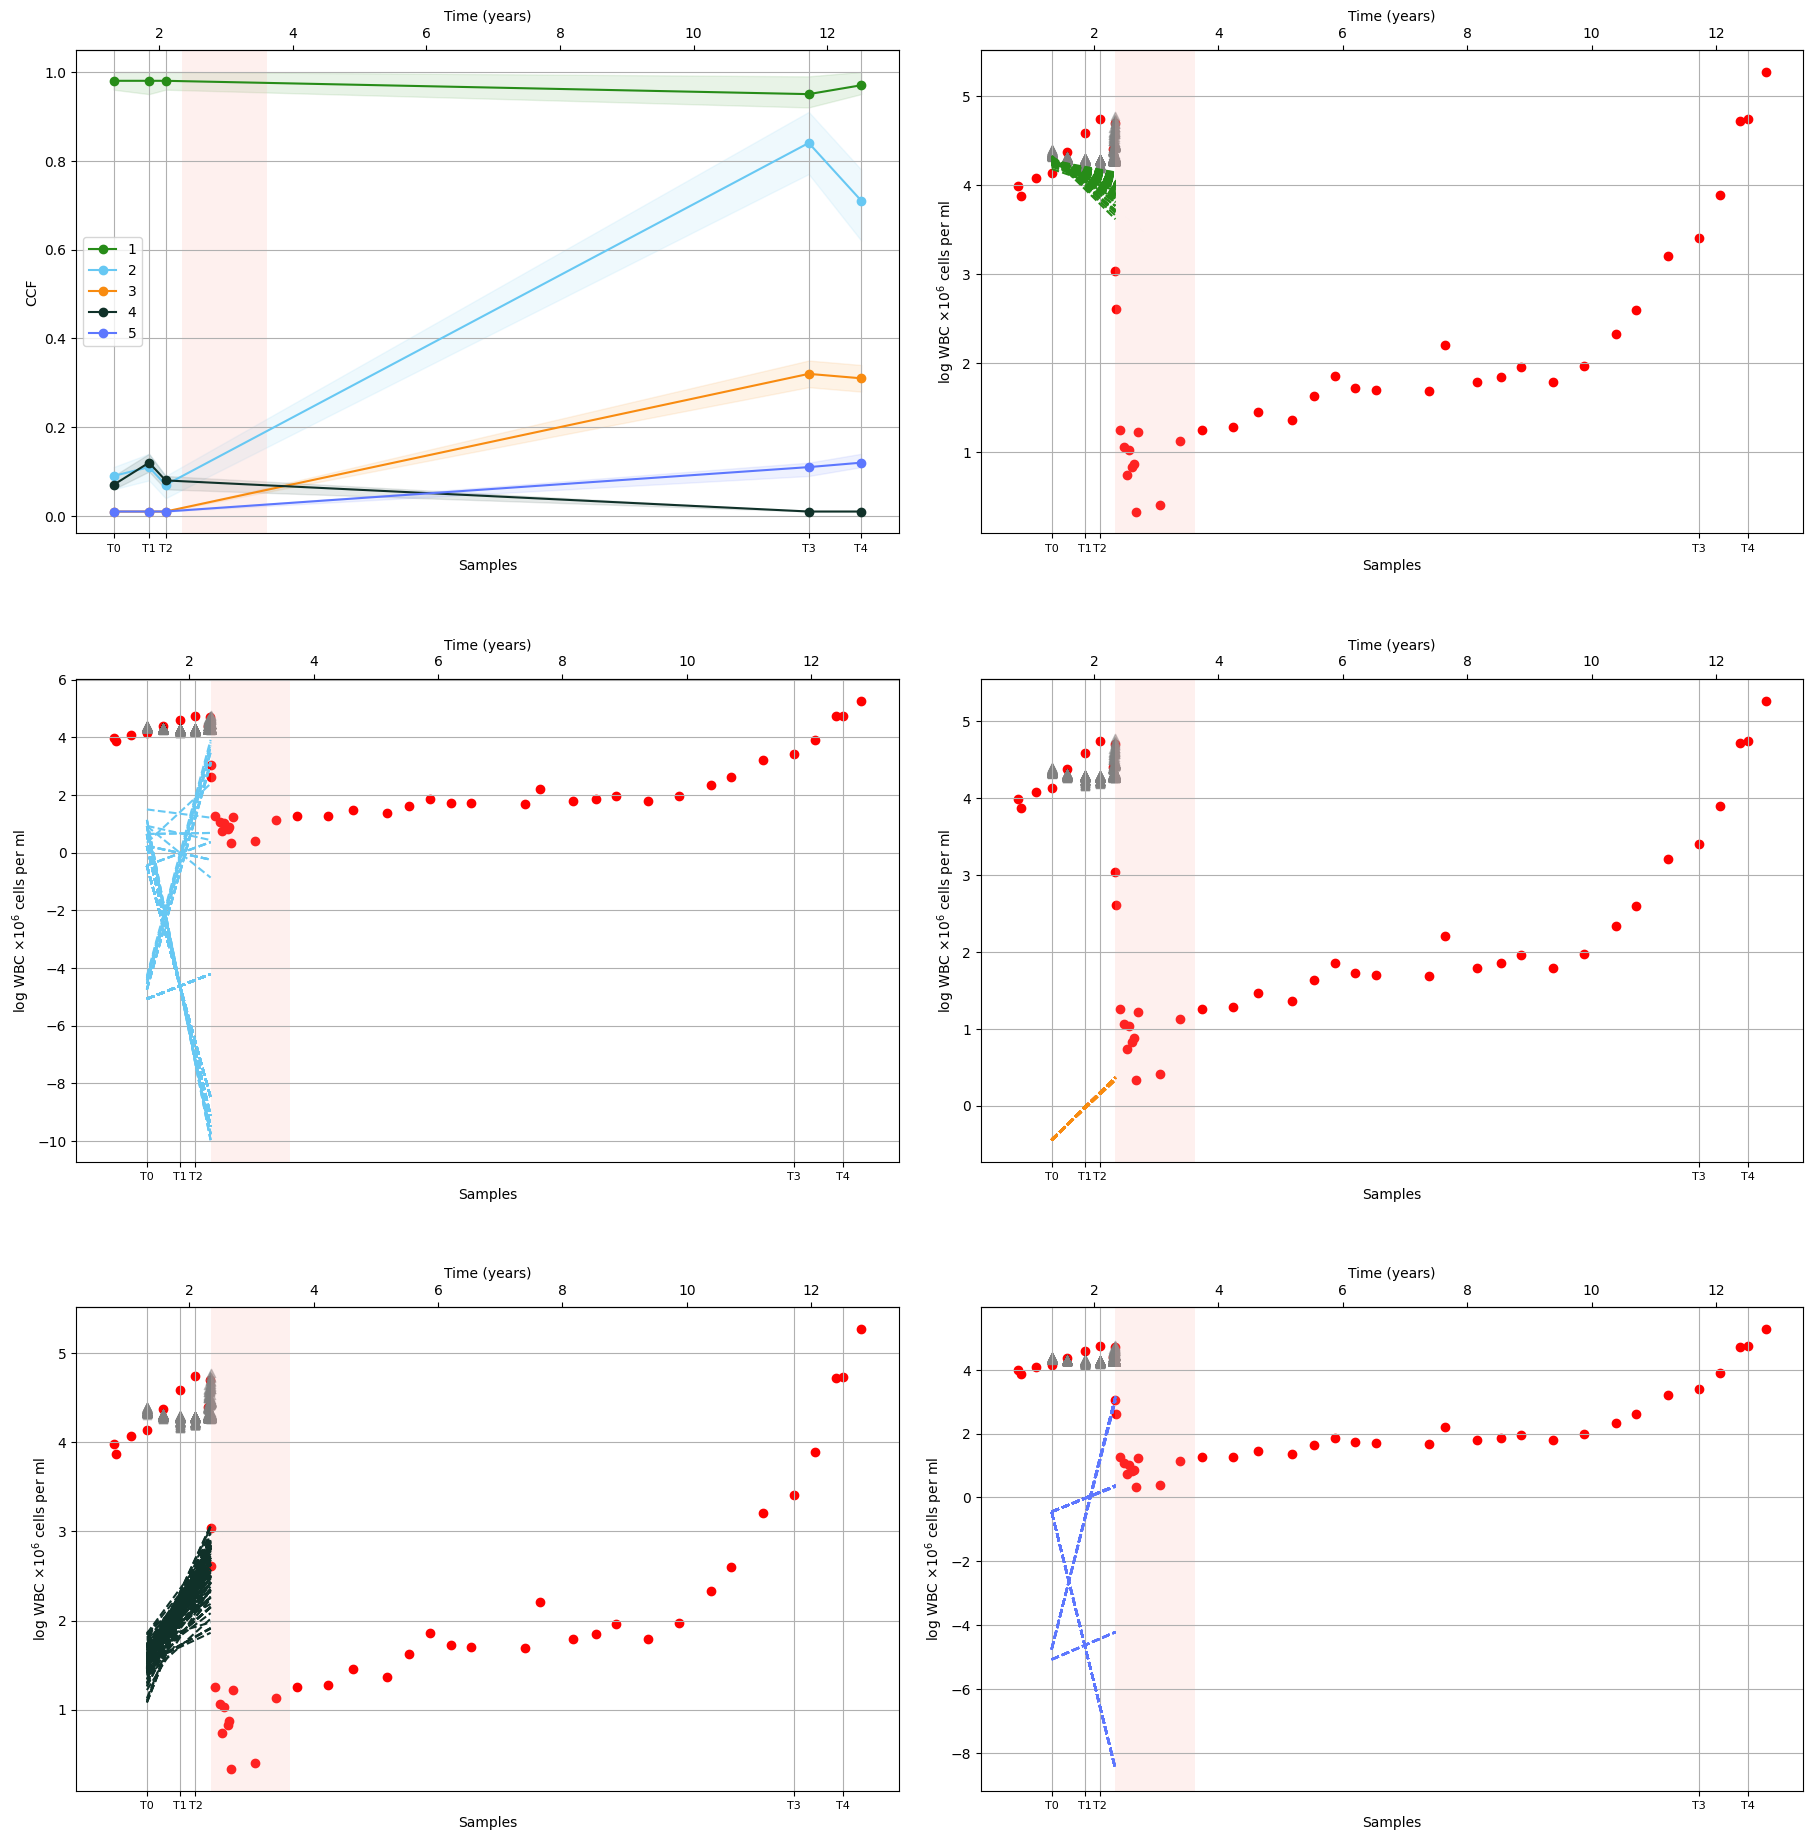

In [58]:
fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(18,18))
fig.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.3)

tick_num = len(sample_list)

tick_list = ['T'+ str(i) for i in range(tick_num)]


slopes_mcmc_bf = {}


def plot_mcmc_model(ax,  times_sliced, wbc_sliced, cluster, n_clusters,index_samples_model,):
    
        
    # plot total wbc
    
    x_year_selected = [ i/365 for i in np.array(times_selected)]
    ax.scatter(x_year_selected,np.log(wbc_selected), label = 'Total WBC', c = 'red')

    # plot subclones

    # Extrapolate after treatment 
    cluster_cell_population = {}


    for iter_idx in range(250):
        
        X, y = create_inputs(times_sliced, log_subclone_sample_mcmc,iter_idx, index_samples_model)
        
        logsumexp_points = np.log(wbc_sliced)

        # for every mcmc iteration, we create a model
        model = MultiClusterLinearRegression(n_clusters, X, y)

        
        
    
        
        model.fit(logsumexp_points )
        
        
        slopes_mcmc_bf[iter_idx] = model.params[n_clusters:]  
        
        ax.plot(X,model.predict()[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            


        logsumexp_points_model = [logsumexp(yi) for yi in model.predict()]
        
        # ax.plot(predict_year,model.predict(predict_year)[:,cluster-1], '--', color=ClusterColors.get_hex_string(cluster))
            
        ax.scatter(X, logsumexp_points_model,marker='^', color = 'grey', alpha = 0.5)

    
    x_axis = [i/365 for i in times_sample]
    ax.set_xticks(x_axis)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel("Time (years)")
    ax.grid(True)

    
    ax.set_xticklabels(tick_list, fontsize =8)
    ax.set_ylabel(r"log WBC $\times 10^6$ cells per ml")

    
    cmap = plt.get_cmap("Pastel1")
    xlim = ax.get_xlim()[1]
    
    for i, row in treatment.iterrows():
        treatment_name = row.tx
        start = row.tx_start/365
        end = row.tx_end/365
        if np.isnan(end):
            end = xlim
        length = end - start 
        center = (start + end)/2
#         color = color_dict[treatment_name]
        ax.axvspan(xmin = start, xmax= end, label = treatment_name, facecolor= cmap(i), alpha = 0.2)
#         ax.legend(ncol = treatment.shape[0], loc='upper center', bbox_to_anchor=(0.5, -2), fontsize = 'x-large')
        ax.set_xlabel('Samples')


model_helper.plot_ccf(cluster_CCF_df,ax1, times_sample, treatment )

plot_mcmc_model(ax2, times_sliced_bf,wbc_sliced_bf,  1, n_clusters = 5, index_samples_model = slice(0,2), )
plot_mcmc_model(ax3,times_sliced_bf,wbc_sliced_bf,  2, n_clusters = 5, index_samples_model = slice(0,2), )
plot_mcmc_model(ax4, times_sliced_bf,wbc_sliced_bf, 3, n_clusters = 5, index_samples_model = slice(0,2), )
plot_mcmc_model(ax5, times_sliced_bf,wbc_sliced_bf, 4, n_clusters = 5, index_samples_model = slice(0,2), )
plot_mcmc_model(ax6, times_sliced_bf,wbc_sliced_bf, 5, n_clusters = 5, index_samples_model = slice(0,2), )

ax2.legend(ncol = treatment.shape[0], loc='lower center',  bbox_to_anchor=(0.5, -0.6),fontsize = 'x-large')

In [89]:
# Convert dictionary values to a numpy array
data = np.array(list(slopes_mcmc_bf.values()))

# Calculate mean and 95% confidence interval for each column (first, second, third, fourth)
means = np.mean(data, axis=0)
lower_ci = np.percentile(data, 2.5, axis=0)
upper_ci = np.percentile(data, 97.5, axis=0)

for i in range(4):
    print(f"Cluster {i+1}:")
    print(f"  Mean: {means[i]:.4f}")
    print(f"  95% Confidence Interval: {lower_ci[i]:.4f} to {upper_ci[i]:.4f}\n")


Cluster 1:
  Mean: 0.3727
  95% Confidence Interval: -0.9258 to 1.5523

Cluster 2:
  Mean: 0.0870
  95% Confidence Interval: -0.3342 to 0.4135

Cluster 3:
  Mean: 0.2154
  95% Confidence Interval: -0.0576 to 0.4662

Cluster 4:
  Mean: 0.4737
  95% Confidence Interval: 0.1406 to 0.7571

